# Hotel-Sentiment-Analysis-Two

# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Functions

In [10]:
def check_null_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.legend(unique)
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_step_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_word_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split()
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/hotel.csv")
df

,Unnamed: 0,content,translated_content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...","Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,"After installed, the app stuck with white display",3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...","Cannot submit the data verification, even my i...",3,1
3,4,Aplilasi restart mulu,The app keep restarting,3,1
4,5,"udah mahal , makanan ga enak, banyak lalat","Overpriced, bad food, too many flies",2,0
...,...,...,...,...,...
695,696,Mohon yang bersihin kamar mandi laki2 khusus l...,Please clean the men's bathrooms specifically ...,2,0
696,697,Kurang kedap suara. Kebangun gara2 pod sebelah...,Loading...,2,0
697,698,Would be nice if people could leave luggage af...,Would be nice if people could leave luggage af...,2,0
698,699,Matrasnya ternyata keras bgt\nDiluar itu so fa...,The mattress turned out to be really hard\nApa...,2,0


# Check for Nulls And Dupes

In [4]:
check_null_dupes(df)

The amount of Nulls: Unnamed: 0            0
content               0
translated_content    0
priority_score        0
problem_domain        0
dtype: int64
The amount of dupes: 0


# Check For Class Imbalance

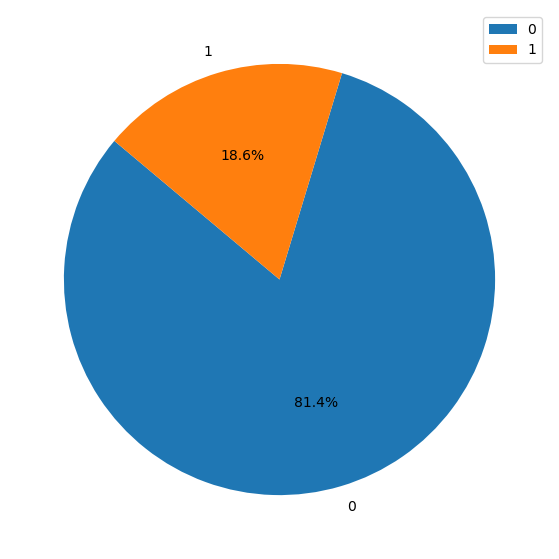

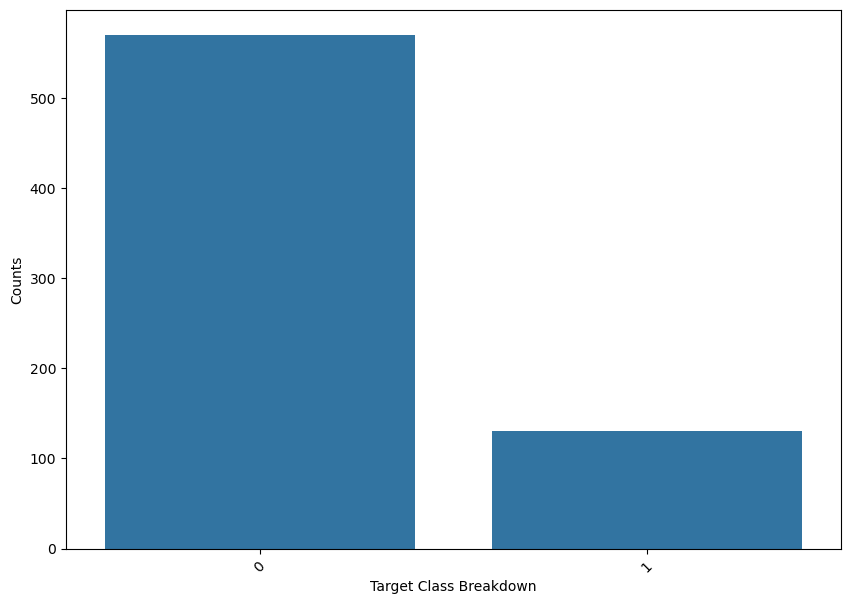

In [6]:
check_class_imbalance(df["problem_domain"])

# Skewed Dataset

# Drop uneeded columns

In [11]:
df.drop(["Unnamed: 0", "content"], axis=1, inplace=True)